Extracting the Trips

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('cleaned_data.csv',index_col=0)
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

trips = []
trip = []
in_trip = False
for idx, row in df.iterrows():  #trip starts when engine_rpm increases from zero (engine starts) and ends when engine_rpm again reaches zero (engine turns off)
    if row['engine_rpm'] > 0:
        if not in_trip:         #checking if the car was already in trip or not
            in_trip = True      #starting a new trip as car was not in a trip
            trip = []
        trip.append(row)
    elif row['engine_rpm'] == 0:
        if in_trip:             #since there are many zero value, so checking if the car was already in a trip if yes then end the trip
            in_trip = False
            if trip:
                trips.append(pd.DataFrame(trip)) #adding the trip to the trips list


Preparing the Data

In [9]:
for i in trips:
    duration = (i.iloc[-1]['time_stamp'] - i.iloc[0]['time_stamp']).total_seconds()
    i['duration (mins)'] = duration / 60

    i['time_diff'] = i['time_stamp'].diff().dt.total_seconds()
    i['time_till_speed_continued'] = i['time_diff'].shift(-1)
    i['final_speed'] = i['vehicle_speed'].shift(-1)
    i['acceleration'] = ((i['final_speed']- i['vehicle_speed'])*1000/3600) / i['time_till_speed_continued']
    i['distance'] = round(((i['vehicle_speed']*1000/3600)*i['time_till_speed_continued']) + (0.5*i['acceleration']*(i['time_till_speed_continued']**2)),2)
    i['distance'] = i['distance']/1000

    temp = i.iloc[-1]['vehicle_speed']*1000/3600
    i.at[i.index[-1],'acceleration'] = (0-temp)/2
    i.at[i.index[-1],'distance'] = round(temp*2 + 0.5*((0-temp)/2)*4) /1000


    maf = (i['mass_air_flow_rate'] *i['time_till_speed_continued']).sum() / i['time_till_speed_continued'].sum() /1000
    far = i['o_s1_b1_fuel_air_equivalence_ratio'].mean()

    fuel_mass_rate = maf / far
    fuel_consumption_kg = fuel_mass_rate * duration

    i['fuel_consumption (liters)'] = fuel_consumption_kg / 0.75


lst = []
for i in range(len(trips)):
    if trips[i]['vehicle_speed'].mean() != 0:
        lst.append(trips[i])

df = pd.DataFrame()
for i in range(len(lst)):
    if lst[i]['vehicle_speed'].mean() != 0:
        lst[i]['trip'] = i+1
        df = pd.concat([df,lst[i]])


df = df.set_index('trip')

Speed Analysis

Number of Trips: 117
Average Speed: 19.41
Maximum Speed: 109.0


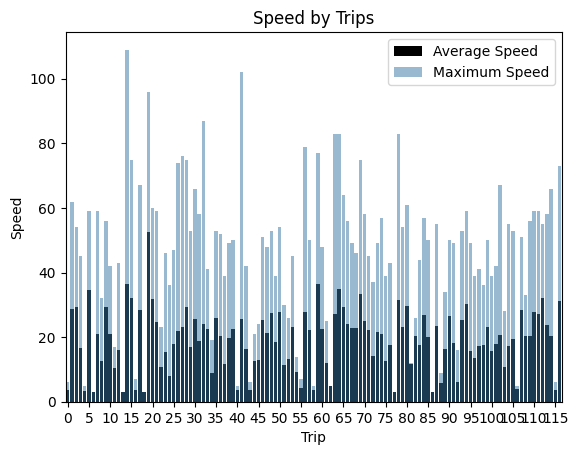

In [10]:
speed_analysis = {'avg_speed':[], 'max_speed':[]}
data =  df.groupby('trip')
for trip, group in data:
    speed_analysis['avg_speed'].append(group.loc[group['vehicle_speed']!=0,'vehicle_speed'].mean())
    speed_analysis['max_speed'].append(group['vehicle_speed'].max())

temp = pd.DataFrame(speed_analysis)

print('Number of Trips:',len(temp))
print('Average Speed:',round(temp['avg_speed'].mean(),2))
print('Maximum Speed:',temp['max_speed'].max())

fig, ax = plt.subplots()
sns.barplot(temp, x=temp.index, y='avg_speed', ax=ax, label='Average Speed',color='k')
sns.barplot(temp, x=temp.index, y='max_speed',ax=ax, label='Maximum Speed',alpha=0.5)
ax.set_xticks(ticks=[i for i in range(0,len(temp),5)])
ax.set(title='Speed by Trips',xlabel='Trip',ylabel='Speed')
ax.legend()
plt.show()

Fuel Consumption Analysis

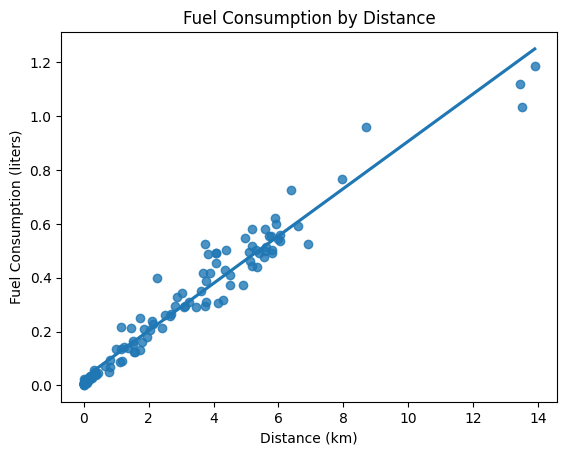

In [11]:
fuel_mean = df.groupby('trip').agg( {'distance': 'sum' ,'fuel_consumption (liters)':'mean'}).reset_index()
sns.regplot(data = fuel_mean, x='distance', y='fuel_consumption (liters)',ci=None).set(title='Fuel Consumption by Distance', \
                        xlabel='Distance (km)', ylabel='Fuel Consumption (liters)')
plt.show()

Selecting the Time Frame

In [12]:
from datetime import datetime

start = input('Enter the starting date (DD-MM-YYYY):')
end = input('Enter the ending date (DD-MM-YYYY):')

end += ' 23:59:59'

start_date = datetime.strptime(start, "%d-%m-%Y")
end_date = datetime.strptime(end, "%d-%m-%Y %H:%M:%S")

selected_df = df[(df['time_stamp'] >= start_date) & (df['time_stamp'] <= end_date)]

stats = selected_df.groupby('trip').agg({'fuel_consumption (liters)':'mean','duration (mins)':'mean'}).reset_index()
fuel = stats['fuel_consumption (liters)'].sum()
dist = selected_df['distance'].sum()

print(f'Summary of the trips between {start_date.strftime('%d-%m-%Y')} and {end_date.strftime('%d-%m-%Y')} \n')
print('Average Speed:',round(selected_df.loc[selected_df['vehicle_speed']!=0,'vehicle_speed'].mean(),2),'kmph')
print('Maximum Speed:',selected_df['vehicle_speed'].max(),'kmph')
print('Total Driving Time:',round(stats['duration (mins)'].sum(),2),'minutes')
print('Distance Travelled:',round(dist,2),'kms')
print('Fuel Consumed:',round(fuel,2),'liters')
print('Mileage for the duration:',round(dist/fuel,2),'km/L')

Summary of the trips between 01-08-2024 and 03-08-2024 

Average Speed: 26.87 kmph
Maximum Speed: 109.0 kmph
Total Driving Time: 88.62 minutes
Distance Travelled: 35.43 kms
Fuel Consumed: 3.32 liters
Mileage for the duration: 10.66 km/L


Plotting the Data

In [13]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=selected_df['time_stamp'], y=selected_df['fuel_consumption (liters)'], 
                         mode='lines', name='Fuel Consumption', yaxis='y1'))

fig.add_trace(go.Scatter(x=selected_df['time_stamp'], y=selected_df['vehicle_speed'], 
                         mode='lines', name='Speed', yaxis='y2'))

fig.add_trace(go.Scatter(x=selected_df['time_stamp'], y=selected_df['acceleration'], 
                         mode='lines', name='Acceleration', yaxis='y3'))

fig.add_trace(go.Scatter(x=selected_df['time_stamp'], y=selected_df['engine_rpm'], 
                         mode='lines', name='RPM', yaxis='y4'))

fig.add_trace(go.Scatter(x=selected_df['time_stamp'], y=selected_df['throttle_position'], 
                         mode='lines', name='Throttle Position', yaxis='y5'))



fig.update_layout(
    title='Performance over the Duration',
    xaxis=dict(title="Time"),

    yaxis=dict(
        title="Fuel Consumption",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue"),
    ),

    yaxis2=dict(
        tickfont=dict(color="red"),
        overlaying="y",
        showticklabels=False
    ),
    
    yaxis3=dict(
        tickfont=dict(color="green"),
        overlaying="y",
        showticklabels=False
    ),
    
    yaxis4=dict(
        tickfont=dict(color="purple"),
        overlaying="y",
        showticklabels=False
    ),

    yaxis5=dict(
        tickfont=dict(color="yellow"),
        overlaying="y",
        showticklabels=False
    ),

    legend_title_text='Parameters'
)

fig.show()


Marking the Trips in Map

In [17]:
import folium
import matplotlib.colors as mcolors

m = folium.Map(location=[24.910303, 67.07708], zoom_start=14)

#Single Selected Trip
# data = selected_df.loc[15]
# data = data[(data['latitude'] != 0) & (data['longitude'] != 0)]
# print(data)

# coord = []
# for i,row in data.iterrows():
#         coord.append([row['latitude'],row['longitude']])

# folium.Marker(location=coord[0], popup=f"Start: {trip}", icon=folium.Icon(color='green')).add_to(m)
# folium.Marker(location=coord[-1], popup=f"End: {trip}", icon=folium.Icon(color='red')).add_to(m)
# folium.PolyLine(locations=coord, color='blue').add_to(m)


#All Trips
df_filtered = selected_df[(selected_df['latitude'] != 0) & (selected_df['longitude'] != 0)]
coord = []
for i,row in df_filtered.iterrows():
        coord.append([row['latitude'],row['longitude']])

folium.Marker(location=coord[0], popup=f"Start: {trip}", icon=folium.Icon(color='green')).add_to(m)
folium.Marker(location=coord[-1], popup=f"End: {trip}", icon=folium.Icon(color='red')).add_to(m)
folium.PolyLine(locations=coord, color='blue').add_to(m)

#All Trips with each being marked

# cmap = plt.get_cmap('viridis', 126)
# colors = [cmap(i) for i in range(cmap.N)]
# hex_colors = [mcolors.rgb2hex(color) for color in colors]

# df_filtered = selected_df[(selected_df['latitude'] != 0) & (selected_df['longitude'] != 0)]
# data = df_filtered.groupby('trip')

# for trip, group in data:
#     coord = []
#     for i,row in group.iterrows():
#             coord.append([row['latitude'],row['longitude']])

#     folium.Marker(location=coord[0], popup=f"Start: {trip}", icon=folium.Icon(color='green')).add_to(m)
#     folium.Marker(location=coord[-1], popup=f"End: {trip}", icon=folium.Icon(color='red')).add_to(m)
#     folium.PolyLine(locations=coord, color=hex_colors[trip-1]).add_to(m)

m


Grading Driver

In [24]:
grade = selected_df[['fuel_consumption (liters)','distance','acceleration','throttle_position','engine_rpm','calculated_engine_load','vehicle_speed']]
fuel_weight = 0.3
acceleration = 0.2
throttle_weight = 0.15
speed_weight = 0.15
rpm_weight = 0.1
load_weight = 0.05
dist = 0.05

print(fuel_weight+acceleration+throttle_weight+speed_weight+rpm_weight+load_weight+dist)


1.0
